In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout
from holidayskr import year_holidays, is_holiday
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
plt.rc('font', family='Malgun Gothic')  # 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [3]:
# 데이터 불러오기
df = pd.read_csv(r"C:\Users\james\J_Data_Lab\Project_KTX\data\ktx_prep_v3_2.csv")

In [4]:
# 미래 날짜 생성
future_dates = pd.date_range(start='2024-04-01', end='2025-12-31', freq='D')

# 일별 데이터프레임 생성
future_df = pd.DataFrame({
    '년도': future_dates.year,
    '월': future_dates.month,
    '일': future_dates.day,
    '요일': future_dates.day_name(),
})

# 공휴일 여부 계산
future_df['공휴일여부'] = future_dates.map(lambda x: 1 if is_holiday(x.strftime('%Y-%m-%d')) else 0)

# 주말 여부 계산
future_df['주말'] = future_df['요일'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

# 평일 여부 계산 
future_df['평일'] = future_df['주말'].apply(lambda x: 0 if x == 1 else 1)

# 월별 집계
monthly_summary = future_df.groupby(['년도', '월']).agg({
    '공휴일여부': 'sum',  # 월별 공휴일 합계
    '주말': 'sum',       # 월별 주말 합계
    '평일': 'sum'        # 월별 평일 합계
}).reset_index()


# 결과 확인
monthly_summary

,년도,월,공휴일여부,주말,평일
0,2024,4,1,8,22
1,2024,5,4,8,23
2,2024,6,1,10,20
3,2024,7,0,8,23
4,2024,8,1,9,22
5,2024,9,3,9,21
6,2024,10,2,8,23
7,2024,11,0,9,21
8,2024,12,1,9,22
9,2025,1,4,8,23


In [26]:
# 1. LSTM 모델 정의
def create_lstm(look_back, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# 2. 주운행선별 처리
all_results = []

for line in df['주운행선'].unique():
    # 주운행선별 데이터 분리 및 정렬
    df_line = df[df['주운행선'] == line].sort_values(['년도', '월']).reset_index(drop=True)

    # 입력 변수 및 타겟 설정
    X = df_line.drop(['승차인원수', '년도', '월'], axis=1)
    y = df_line['승차인원수']

    # 데이터 스케일링
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    input_features = X.columns  # 피처 저장

    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # 모델 선택
    if line == 2:  # LSTM 모델 적용
        # LSTM 입력 데이터 변환
        look_back = X_train.shape[1]  # 입력 시퀀스 길이
        model = create_lstm(look_back, dropout_rate=0.2)

        # 입력 데이터 reshape
        X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        # 모델 훈련
        model.fit(X_train_reshaped, y_train, epochs=50, batch_size=16, 
                  validation_data=(X_test_reshaped, y_test), verbose=1)

    else:  # 다른 주운행선은 XGB 모델 사용
        model = XGBRegressor(random_state=42, n_estimators=100)
        model.fit(X_train, y_train)

    # 3. 미래 데이터 예측
    future_results = []
    last_values = df_line.copy()  # 기존 데이터 복사

    for idx, (year, month) in monthly_summary[['년도', '월']].iterrows():
        # 12개월 전 인덱스 찾기
        prev_index = len(last_values) - 12

        # 6개월 평균 계산
        recent_6_months = last_values.tail(6)  # 최근 6개월 데이터 참조
        korea_cpi_avg = recent_6_months['korea_cpi'].mean()
        KSVKOSPI_avg = recent_6_months['KSVKOSPI'].mean()

        # 입력 데이터 생성
        future_input = pd.DataFrame({
            '년도': [year],
            '월': [month],
            '주운행선': [line],
            '공급차량수': [last_values.iloc[prev_index]['공급차량수']],
            '공급좌석합계수': [last_values.iloc[prev_index]['공급좌석합계수']],
            '승차수입금액': [last_values.iloc[prev_index]['승차수입금액']],
            '승차연인거리': [last_values.iloc[prev_index]['승차연인거리']],
            '좌석거리': [last_values.iloc[prev_index]['좌석거리']],
            '상행_KTX': [last_values.iloc[prev_index]['상행_KTX']],
            '상행_KTX-산천': [last_values.iloc[prev_index]['상행_KTX-산천']],
            '상행_KTX-호남': [last_values.iloc[prev_index]['상행_KTX-호남']],
            '하행_KTX': [last_values.iloc[prev_index]['하행_KTX']],
            '하행_KTX-산천': [last_values.iloc[prev_index]['하행_KTX-산천']],
            '하행_KTX-호남': [last_values.iloc[prev_index]['하행_KTX-호남']],
            '공휴일여부': [monthly_summary.loc[idx, '공휴일여부']],
            '평일': [monthly_summary.loc[idx, '평일']],
            '주말': [monthly_summary.loc[idx, '주말']],
            'korea_cpi': [korea_cpi_avg],  # 6개월 평균
            'KSVKOSPI': [KSVKOSPI_avg],  # 6개월 평균
            '승차인원수_lag1': [last_values.iloc[prev_index]['승차인원수']],
            '승차인원수_lag2': [last_values.iloc[prev_index-1]['승차인원수']],
            '승차인원수_lag3': [last_values.iloc[prev_index-2]['승차인원수']],
        })

        # 스케일링 적용
        future_scaled = scaler.transform(future_input[input_features])

        # 예측
        if line == 2:  # LSTM 예측
            future_scaled = future_scaled.reshape((1, look_back, 1))  # 3차원 변환
            prediction = model.predict(future_scaled).flatten()[0]
        else:  # XGB 예측
            prediction = model.predict(future_scaled)[0]

        # 결과 저장
        future_input['예측_승차인원수'] = prediction
        future_results.append(future_input)

        # 데이터 업데이트
        new_row = future_input.copy()
        new_row['승차인원수'] = prediction
        last_values = pd.concat([last_values, new_row]).reset_index(drop=True)

    # 주운행선별 결과 저장
    all_results.append(pd.concat(future_results, axis=0))

# 최종 결과 결합
final_results = pd.concat(all_results, axis=0)

Epoch 1/50


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 292014260224.0000 - val_loss: 247557521408.0000
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 289421361152.0000 - val_loss: 247557455872.0000
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 281855623168.0000 - val_loss: 247557439488.0000
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 282069041152.0000 - val_loss: 247557406720.0000
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 291913859072.0000 - val_loss: 247557373952.0000
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 286468800512.0000 - val_loss: 247557341184.0000
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 290599862272.0000 - val_loss: 247557324800.0000
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 288332218368.0000 - val_loss: 247557308416.0000
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 284774563840.0000 - val_loss: 247557259264.0000
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 2890335

In [27]:
final_results

,년도,월,주운행선,공급차량수,공급좌석합계수,승차수입금액,승차연인거리,좌석거리,상행_KTX,상행_KTX-산천,...,하행_KTX-호남,공휴일여부,평일,주말,korea_cpi,KSVKOSPI,승차인원수_lag1,승차인원수_lag2,승차인원수_lag3,예측_승차인원수
0,2024,4,0,58560.0,3098080.0,1.078436e+11,7.904313e+09,1.267517e+10,1575.0,44.0,...,106.0,1,22,8,0.032167,17.019216,3.281372e+06,3.152500e+06,3.114093e+06,3.279514e+06
0,2024,5,0,59882.0,3168137.0,1.138231e+11,8.384620e+09,1.296078e+10,3220.0,86.0,...,224.0,4,23,8,0.031194,16.839173,3.460800e+06,3.281372e+06,3.152500e+06,3.479549e+06
0,2024,6,0,58560.0,3098394.0,1.085103e+11,7.937638e+09,1.267656e+10,1575.0,43.0,...,107.0,1,20,10,0.030894,16.875172,3.274361e+06,3.460800e+06,3.281372e+06,3.273168e+06
0,2024,7,0,59962.0,3171834.0,1.107451e+11,8.045009e+09,1.297240e+10,1610.0,50.0,...,110.0,0,23,8,0.030709,17.188314,3.279768e+06,3.274361e+06,3.460800e+06,3.297832e+06
0,2024,8,0,59966.0,3172197.0,1.143849e+11,8.421385e+09,1.297491e+10,1611.0,48.0,...,110.0,1,22,9,0.031161,17.130155,3.352224e+06,3.279768e+06,3.274361e+06,3.394181e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2025,8,2,9684.0,490818.0,1.678905e+10,1.191402e+09,1.830042e+09,93.0,213.0,...,182.0,1,21,10,0.031101,17.044729,5.273422e+05,5.281694e+05,4.957238e+05,5.273387e+05
0,2025,9,2,9064.0,455097.0,1.578161e+10,1.106723e+09,1.694286e+09,90.0,270.0,...,94.0,0,22,8,0.031097,17.043571,4.573929e+05,5.273422e+05,5.281694e+05,4.572448e+05
0,2025,10,2,9780.0,491274.0,1.745490e+10,1.226698e+09,1.828582e+09,93.0,294.0,...,108.0,6,23,8,0.031094,17.044401,5.458902e+05,4.573929e+05,5.273422e+05,5.460886e+05
0,2025,11,2,9480.0,475518.0,1.660269e+10,1.161795e+09,1.769963e+09,90.0,288.0,...,102.0,0,20,10,0.031093,17.045316,5.034671e+05,5.458902e+05,4.573929e+05,5.034632e+05


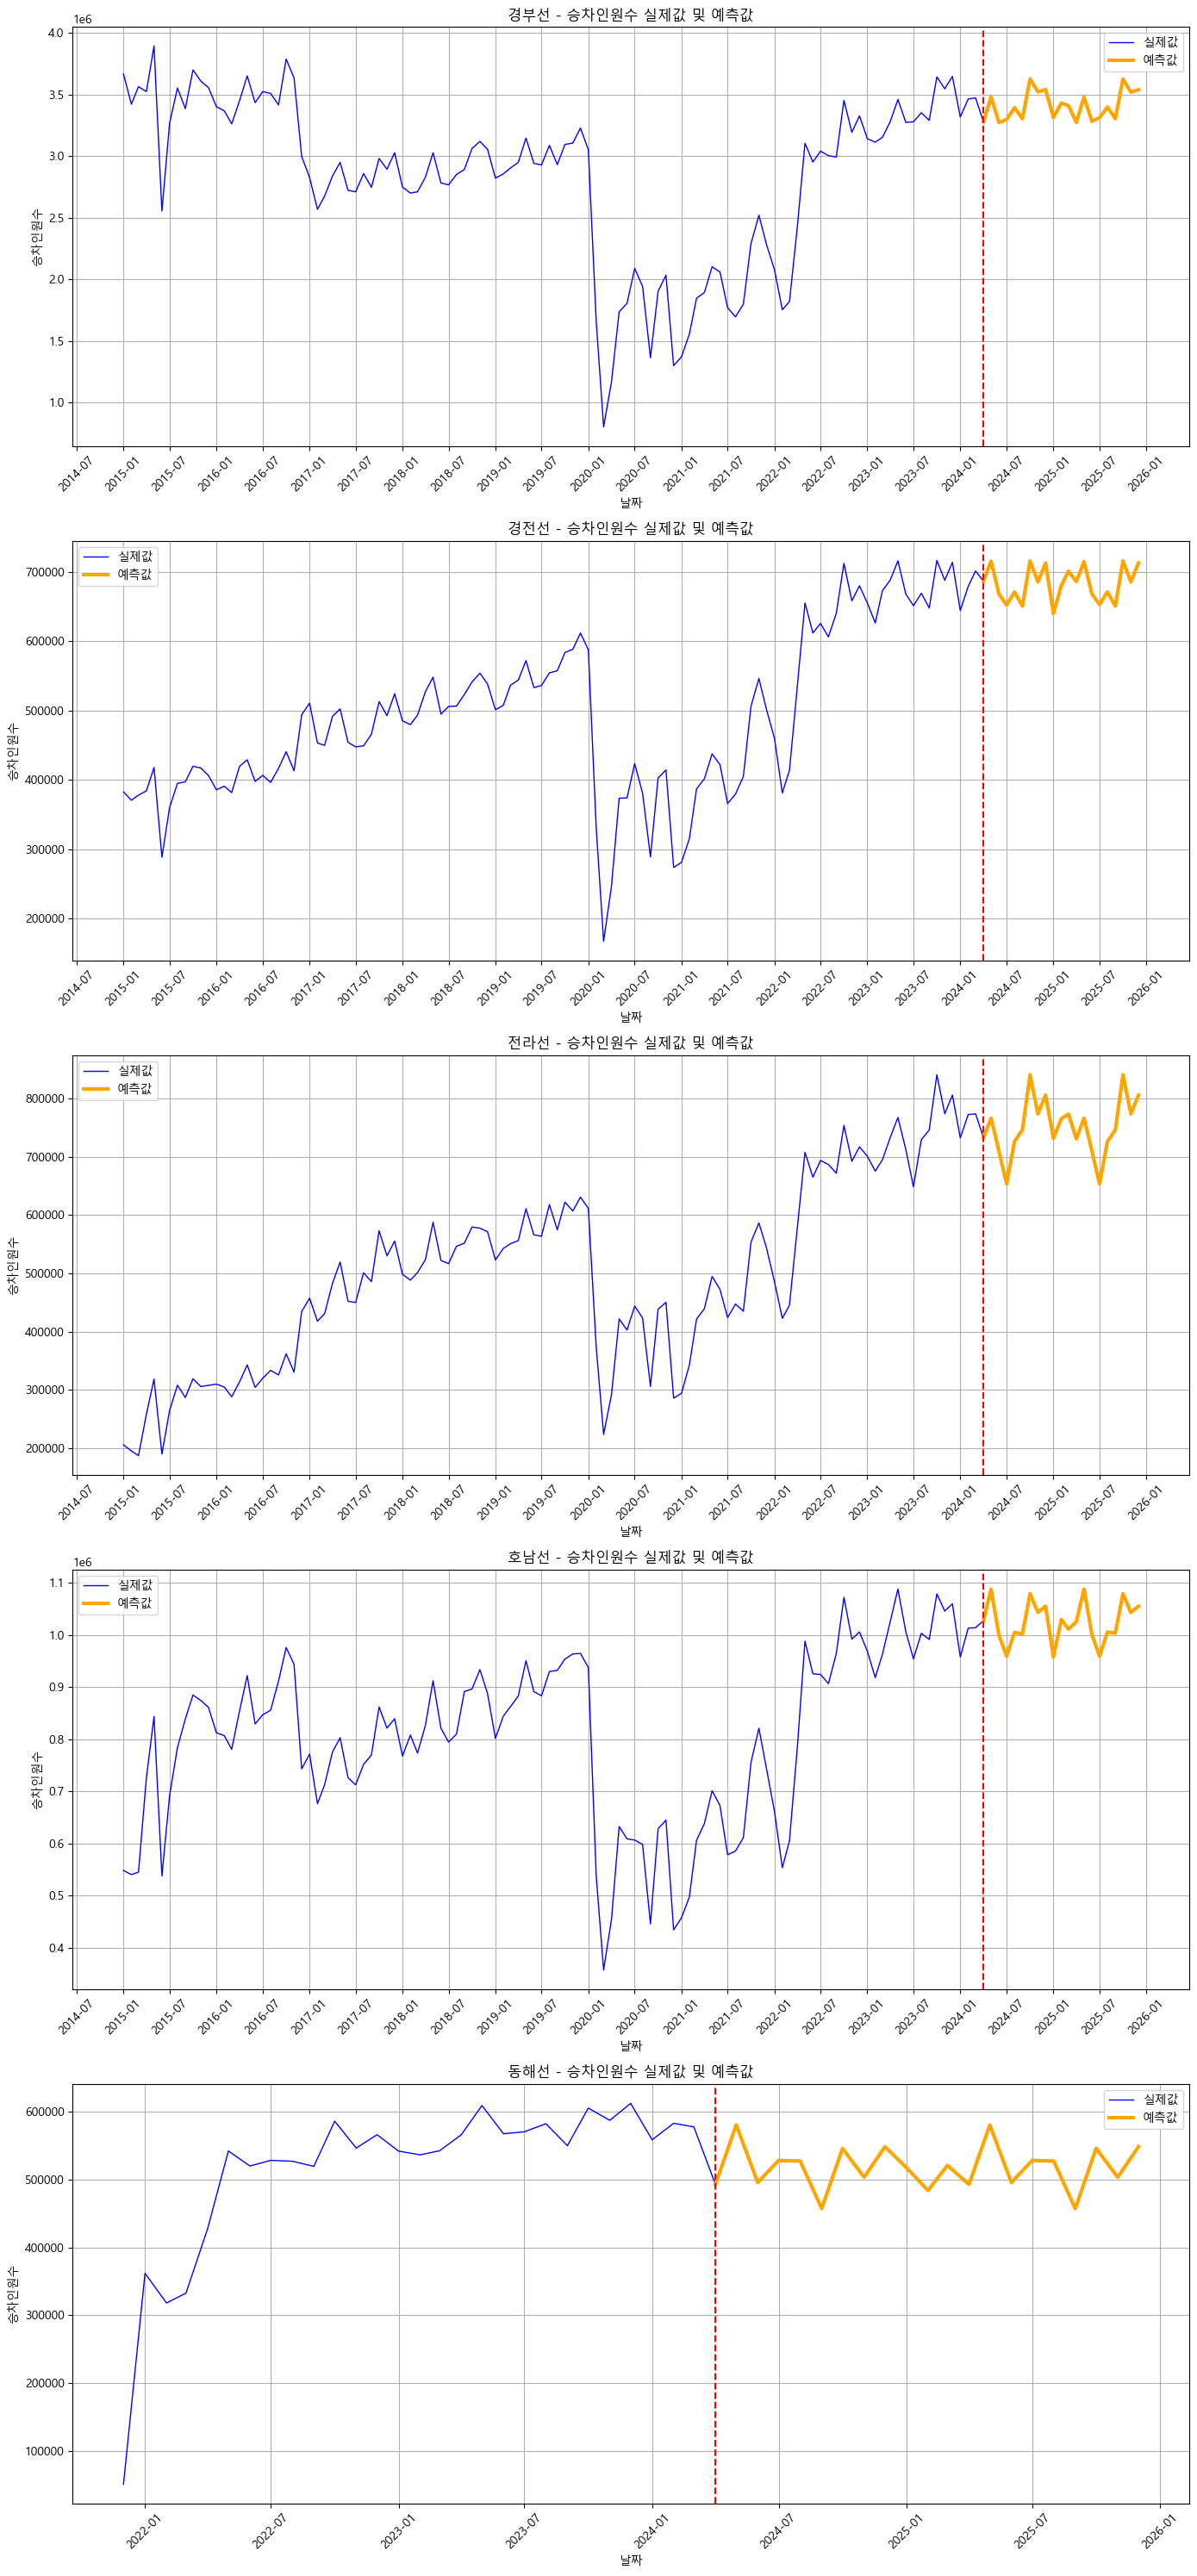

In [29]:
# 데이터 결합 (실제값과 예측값)
# 실제값: 2015년 ~ 2024년 3월
actual_df = df[['년도', '월', '주운행선', '승차인원수']].copy()

# 예측값: 2024년 4월 ~ 2025년 12월
predicted_df = final_results[['년도', '월', '주운행선', '예측_승차인원수']].copy()
predicted_df.rename(columns={'예측_승차인원수': '승차인원수'}, inplace=True)  # 컬럼명 통일

# 데이터 결합
combined_df = pd.concat([actual_df, predicted_df], axis=0)

# 날짜 데이터 생성 (년도와 월 기준으로 날짜 생성)
combined_df['날짜'] = pd.to_datetime(
    combined_df['년도'].astype(str) + '-' + combined_df['월'].astype(str) + '-01'
)

# 실제값/예측값 구분 추가
combined_df['구분'] = ['실제값'] * len(actual_df) + ['예측값'] * len(predicted_df)

# 날짜 순서대로 정렬
combined_df = combined_df.sort_values(by='날짜').reset_index(drop=True)

# 주운행선별 시각화
lines = combined_df['주운행선'].unique()
line_mapping = {0: '경부선', 1: '경전선', 2: '동해선', 3: '전라선', 4: '호남선'}

fig, axes = plt.subplots(len(lines), 1, figsize=(14, 6 * len(lines)), sharex=False)  # 공유 x축 해제

for i, line in enumerate(lines):
    ax = axes[i] if len(lines) > 1 else axes  # 주운행선 개수에 따른 서브플롯 처리
    subset = combined_df[combined_df['주운행선'] == line]

    # 실제값 + 예측값 연결 
    ax.plot(subset['날짜'], subset['승차인원수'],
            label='실제값', linewidth=1, color='blue')

    # 예측 구간 강조 (
    pred_subset = subset[subset['구분'] == '예측값']
    ax.plot(pred_subset['날짜'], pred_subset['승차인원수'],
            label='예측값', linewidth=3, color='orange')


    # 그래프 꾸미기
    ax.set_title(f"{line_mapping[line]} - 승차인원수 실제값 및 예측값")
    ax.set_xlabel('날짜')
    ax.set_ylabel('승차인원수')
    ax.legend()
    ax.grid(True)

    # x축 설정 (6개월 간격 표시)
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))  # 1월, 7월 표시
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 'YYYY-MM' 형식
    ax.tick_params(axis='x', rotation=45)  # x축 라벨 회전
    ax.axvline(x=pd.to_datetime('2024-04-01'), color='r', linestyle='--', label='예측 시작')
    

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()